In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import os
import sys
import copy
import time
import datetime
import random
import math
import warnings
warnings.filterwarnings('ignore')
from typing import List

In [3]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

In [4]:
import matplotlib
# mpl.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt 
from matplotlib.colors import ListedColormap

matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 5
plt.rcParams['figure.figsize'] = [12, 12]

In [5]:
import numpy as np
import scipy
import seaborn as sns

from tqdm.notebook import tqdm, trange

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [49]:
from captum.attr import IntegratedGradients, Saliency, FeatureAblation

# Create Pseudo Data

In [8]:
seed = 42
test_size = 0.2

In [9]:
X_var = 1
y_var = 0.1

In [10]:
num_features = 1
num_noises = 10
num_data = 10000

In [11]:
X = np.random.randn(num_data, num_features+num_noises)*X_var
y_true = X[:, :1]**2
y_noise = np.random.randn(num_data, 1)*y_var
y = y_true+y_noise

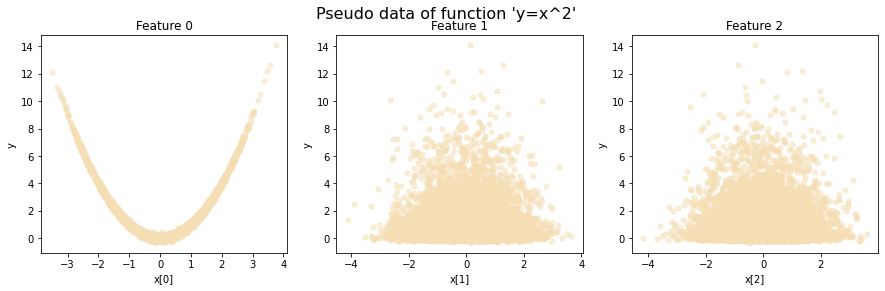

In [12]:
fig, axs = plt.subplots(nrows = math.ceil(num_features/3), ncols=3, figsize=(15, 4))
for i, ax in enumerate(axs.flat): 
    if i==0:
        fig.suptitle("Pseudo data of function 'y=x^2'", fontsize=16)
    x = X[:,i]
    ax.scatter(x, y, c='wheat', alpha=0.5)

    ax.set_title(f'Feature {i}')
    ax.set_xlabel(f'x[{i}]')
    ax.set_ylabel('y')
plt.show()

In [13]:
plt.close()

# Create MLP Regressor to Learn a Proper Function

In [14]:
class LinearBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.GELU(),
        )

    def forward(self, x: Tensor)-> Tensor:
        x = self.net(x)
        return x

In [15]:
class MLPRegressor(nn.Module):
    def __init__(self, in_channels: int, sizes: List[int], p: int=0.2):
        super().__init__()
        self.blocks = nn.ModuleList([
            LinearBlock(in_channels, sizes[0]),
            *[LinearBlock(sizes[i], sizes[i+1]) for i in range(len(sizes)-1)]
        ])
        self.dropout = nn.Dropout(p)
        self.project = nn.Linear(sizes[-1], 1)

    def forward(self, x: Tensor)-> Tensor:
        for block in self.blocks:
            x = block(x)
        x = self.dropout(x)
        x = self.project(x)
        return x

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [17]:
train_set = TensorDataset(Tensor(X_train), Tensor(y_train))
train_loader = DataLoader(train_set, batch_size=y_train.shape[0])
test_set = TensorDataset(Tensor(X_test), Tensor(y_test))
test_loader = DataLoader(test_set, batch_size=y_test.shape[0])

In [18]:
hidden_layer_sizes = (100,100,100)
num_epochs = 1000

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
regr = MLPRegressor(num_features+num_noises, hidden_layer_sizes, p=0.0)
regr.to(device)
regr.train()

MLPRegressor(
  (blocks): ModuleList(
    (0): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=11, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
    (1): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
    (2): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (project): Linear(in_features=100, out_features=1, bias=True)
)

In [21]:
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(regr.parameters(), 0.0001)

In [22]:
def train(model, dataloader, num_epochs, optimizer):
    pbar = trange(num_epochs, desc='Train', unit='epoch', initial=0)
    for epoch in pbar:  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        pbar.set_postfix(loss = '%.3f' % running_loss)
        running_loss = 0.0

In [23]:
train(regr, train_loader, num_epochs, optimizer)

Train:   0%|          | 0/1000 [00:00<?, ?epoch/s]

In [24]:
y_pred = regr(Tensor(X_test).to(device)).detach().cpu().numpy()
score = mean_absolute_error(y_pred, y_test)

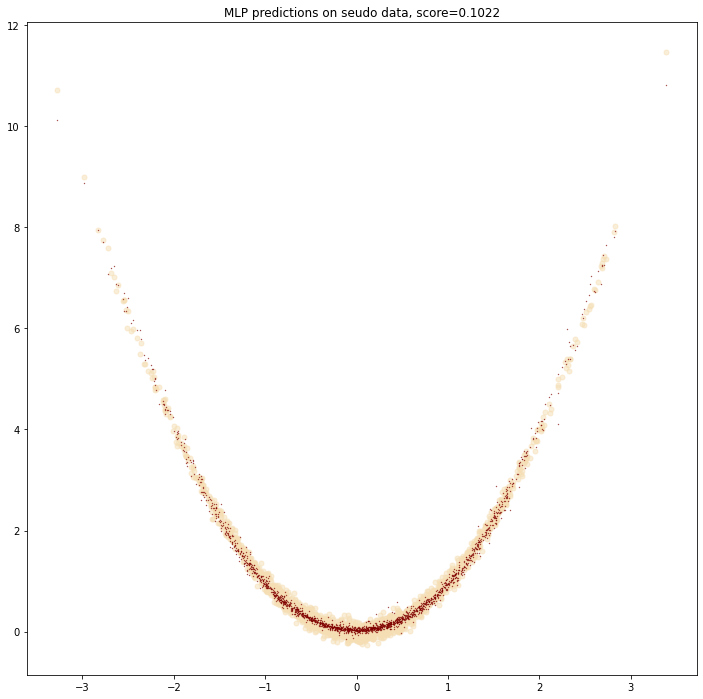

In [25]:
plt.scatter(X_test[:,0], y_test, c='wheat', alpha=0.5)
plt.scatter(X_test[:,0], y_pred, s=0.1, c='maroon', alpha=1)
plt.title(f"MLP predictions on seudo data, score={score:.4f}")
plt.show()

In [26]:
plt.close()

# Local Attribution Inspection

In [57]:
ig = IntegratedGradients(regr)
sa = Saliency(regr)
dl = DeepLift(regr)
fa = FeatureAblation(regr)

In [61]:
ig_attr_test = ig.attribute(Tensor(X_test).to(device), n_steps=20)

In [53]:
sa_attr_test = sa.attribute(Tensor(X_test).to(device))

In [62]:
dl_attr_test = dl.attribute(Tensor(X_test).to(device))

In [63]:
fa_attr_test = fa.attribute(Tensor(X_test).to(device))

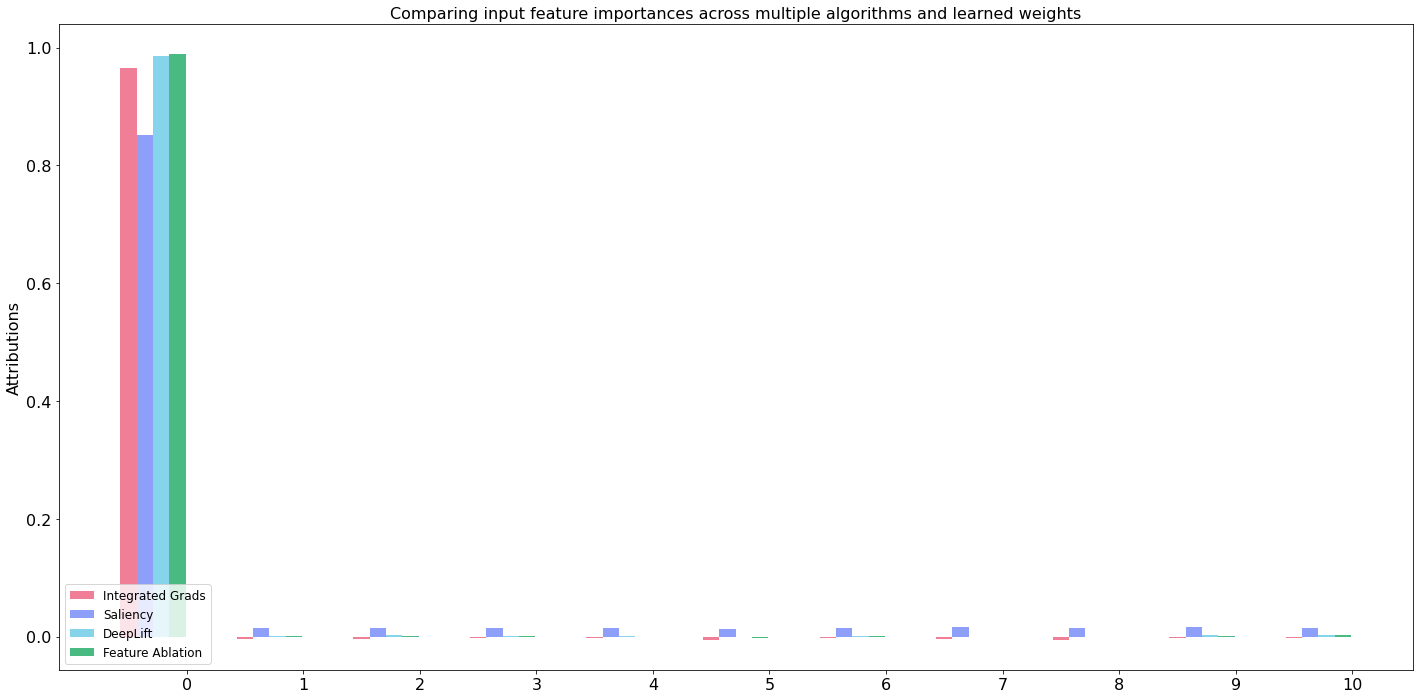

In [70]:
# prepare attributions for visualization

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(range(num_features+num_noises))

ig_attr_test_sum = ig_attr_test.detach().cpu().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

sa_attr_test_sum = sa_attr_test.detach().cpu().numpy().sum(0)
sa_attr_test_norm_sum = sa_attr_test_sum / np.linalg.norm(sa_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.detach().cpu().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().cpu().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

width = 0.14
legends = ['Integrated Grads', 'Saliency', 'DeepLift', 'Feature Ablation']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, sa_attr_test_norm_sum, width, align='center', alpha=0.6, color='#4260f5')
ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3*width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()